In [1]:
import torch
from torch import nn
from torchviz import make_dot

In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import logging
import random
from collections import OrderedDict, defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data
from tqdm import trange

from experiments.pfedhn_pc.models import CNNHyperPC, CNNTargetPC, LocalLayer
from experiments.pfedhn_pc.node import BaseNodesForLocal
from experiments.utils import get_device, set_logger, set_seed, str2bool

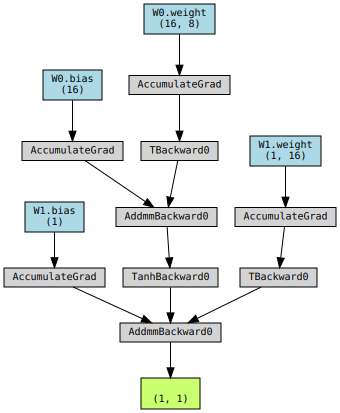

In [4]:
model = nn.Sequential()
model.add_module("W0", nn.Linear(8, 16))
model.add_module("tanh", nn.Tanh())
model.add_module("W1", nn.Linear(16, 1))

x = torch.randn(1, 8)

make_dot(model(x), params=dict(model.named_parameters()))

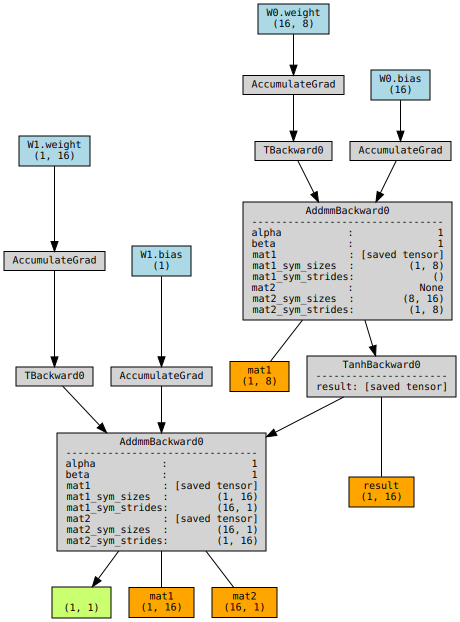

In [5]:
make_dot(
    model(x), params=dict(model.named_parameters()), show_attrs=True, show_saved=True
)

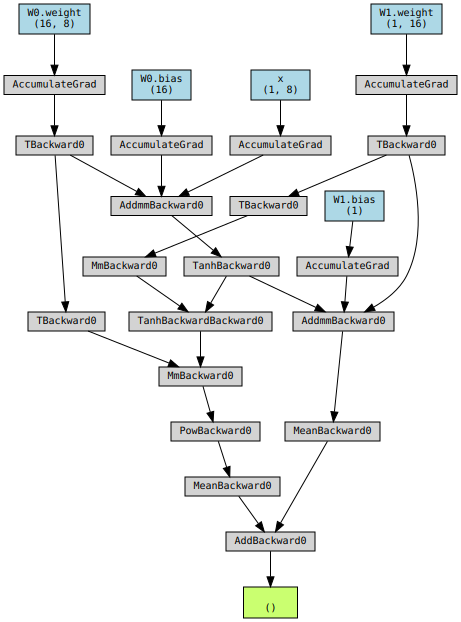

In [6]:
x = torch.randn(1, 8).requires_grad_(True)


def double_backprop(inputs, net):
    y = net(x).mean()
    (grad,) = torch.autograd.grad(y, x, create_graph=True, retain_graph=True)
    return grad.pow(2).mean() + y


make_dot(
    double_backprop(x, model), params=dict(list(model.named_parameters()) + [("x", x)])
)

In [7]:
def eval_model(nodes, num_nodes, hnet, net, criteria, device, split):
    curr_results = evaluate(nodes, num_nodes, hnet, net, criteria, device, split=split)
    total_correct = sum([val["correct"] for val in curr_results.values()])
    total_samples = sum([val["total"] for val in curr_results.values()])
    avg_loss = np.mean([val["loss"] for val in curr_results.values()])
    avg_acc = total_correct / total_samples

    all_acc = [val["correct"] / val["total"] for val in curr_results.values()]

    return curr_results, avg_loss, avg_acc, all_acc


@torch.no_grad()
def evaluate(
    nodes: BaseNodesForLocal, num_nodes, hnet, net, criteria, device, split="test"
):
    hnet.eval()
    results = defaultdict(lambda: defaultdict(list))

    for node_id in range(num_nodes):  # iterating over nodes
        running_loss, running_correct, running_samples = 0.0, 0.0, 0.0
        if split == "test":
            curr_data = nodes.test_loaders[node_id]
        elif split == "val":
            curr_data = nodes.val_loaders[node_id]
        else:
            curr_data = nodes.train_loaders[node_id]

        weights = hnet(torch.tensor([node_id], dtype=torch.long).to(device))
        net.load_state_dict(weights)

        for batch_count, batch in enumerate(curr_data):
            img, label = tuple(t.to(device) for t in batch)
            net_out = net(img)
            pred = nodes.local_layers[node_id](net_out)
            running_loss += criteria(pred, label).item()
            running_correct += pred.argmax(1).eq(label).sum().item()
            running_samples += len(label)

        results[node_id]["loss"] = running_loss / (batch_count + 1)
        results[node_id]["correct"] = running_correct
        results[node_id]["total"] = running_samples

    return results

In [8]:
parser = argparse.ArgumentParser(
    description="Federated Hypernetwork with local layers experiment"
)

#############################
#       Dataset Args        #
#############################
parser.add_argument(
    "--data-name",
    type=str,
    default="cifar10",
    choices=["cifar10", "cifar100"],
    help="data name",
)
parser.add_argument("--data-path", type=str, default="data", help="data path")
parser.add_argument("--num-nodes", type=int, default=50)

##################################
#       Optimization args        #
##################################
parser.add_argument("--num-steps", type=int, default=5000)
parser.add_argument("--batch-size", type=int, default=64)
parser.add_argument("--inner-steps", type=int, default=50, help="number of inner steps")
parser.add_argument(
    "--optim", type=str, default="sgd", choices=["adam", "sgd"], help="learning rate"
)

################################
#       Model Prop args        #
################################
parser.add_argument("--n-hidden", type=int, default=3, help="num. hidden layers")
parser.add_argument(
    "--inner-lr", type=float, default=5e-3, help="learning rate for inner optimizer"
)
parser.add_argument("--lr", type=float, default=5e-2, help="learning rate")
parser.add_argument("--wd", type=float, default=1e-3, help="weight decay")
parser.add_argument("--inner-wd", type=float, default=5e-5, help="inner weight decay")
parser.add_argument("--embed-dim", type=int, default=-1, help="embedding dim")
parser.add_argument(
    "--embed-lr", type=float, default=None, help="embedding learning rate"
)
parser.add_argument("--hyper-hid", type=int, default=100, help="hypernet hidden dim")
parser.add_argument(
    "--spec-norm", type=str2bool, default=False, help="hypernet hidden dim"
)
parser.add_argument(
    "--nkernels", type=int, default=16, help="number of kernels for cnn model"
)

#############################
#       General args        #
#############################
parser.add_argument("--gpu", type=int, default=0, help="gpu device ID")
parser.add_argument(
    "--eval-every", type=int, default=30, help="eval every X selected epochs"
)
parser.add_argument(
    "--save-path",
    type=str,
    default="pfedhn_pc_cifar_res",
    help="dir path for output file",
)
parser.add_argument("--seed", type=int, default=42, help="seed value")

args = parser.parse_args({})
assert (
    args.gpu <= torch.cuda.device_count()
), f"--gpu flag should be in range [0,{torch.cuda.device_count() - 1}]"

set_logger()
set_seed(args.seed)

device = get_device(gpus=args.gpu)

if args.data_name == "cifar10":
    args.classes_per_node = 2
else:
    args.classes_per_node = 10

In [10]:
def train(
    data_name: str,
    data_path: str,
    classes_per_node: int,
    num_nodes: int,
    steps: int,
    inner_steps: int,
    optim: str,
    lr: float,
    inner_lr: float,
    embed_lr: float,
    wd: float,
    inner_wd: float,
    embed_dim: int,
    hyper_hid: int,
    n_hidden: int,
    n_kernels: int,
    bs: int,
    device,
) -> None:
    ###############################
    # init nodes, hnet, local net #
    ###############################

    nodes = BaseNodesForLocal(
        data_name=data_name,
        data_path=data_path,
        n_nodes=num_nodes,
        base_layer=LocalLayer,
        layer_config={"n_input": 84, "n_output": 10 if data_name == "cifar10" else 100},
        base_optimizer=torch.optim.SGD,
        optimizer_config=dict(lr=inner_lr, momentum=0.9, weight_decay=inner_wd),
        device=device,
        batch_size=bs,
        classes_per_node=classes_per_node,
    )

    embed_dim = embed_dim
    if embed_dim == -1:
        logging.info("auto embedding size")
        embed_dim = int(1 + num_nodes / 4)

    hnet = CNNHyperPC(
        num_nodes,
        embed_dim,
        hidden_dim=hyper_hid,
        n_hidden=n_hidden,
        n_kernels=n_kernels,
    )
    net = CNNTargetPC(n_kernels=n_kernels)

    hnet = hnet.to(device)
    net = net.to(device)

    ##################
    # init optimizer #
    ##################
    embed_lr = embed_lr if embed_lr is not None else lr
    optimizers = {
        "sgd": torch.optim.SGD(
            [
                {"params": [p for n, p in hnet.named_parameters() if "embed" not in n]},
                {
                    "params": [p for n, p in hnet.named_parameters() if "embed" in n],
                    "lr": embed_lr,
                },
            ],
            lr=lr,
            momentum=0.9,
            weight_decay=wd,
        ),
        "adam": torch.optim.Adam(params=hnet.parameters(), lr=lr),
    }
    optimizer = optimizers[optim]
    criteria = torch.nn.CrossEntropyLoss()

    steps = 1
    inner_steps = 1
    step_iter = trange(steps)

    for step in step_iter:
        hnet.train()

        # select client at random
        node_id = random.choice(range(num_nodes))

        # produce & load local network weights
        weights = hnet(torch.tensor([node_id], dtype=torch.long).to(device))
        net.load_state_dict(weights)

        # init inner optimizer
        inner_optim = torch.optim.SGD(
            net.parameters(), lr=inner_lr, momentum=0.9, weight_decay=inner_wd
        )

        # storing theta_i for later calculating delta theta
        inner_state = OrderedDict({k: tensor.data for k, tensor in weights.items()})

        # inner updates -> obtaining theta_tilda
        for i in range(inner_steps):
            net.train()
            inner_optim.zero_grad()
            optimizer.zero_grad()
            nodes.local_optimizers[node_id].zero_grad()

            batch = next(iter(nodes.train_loaders[node_id]))
            img, label = tuple(t.to(device) for t in batch)

            net_out = net(img)
            pred = nodes.local_layers[node_id](net_out)

            loss = criteria(pred, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 50)
            inner_optim.step()
            nodes.local_optimizers[node_id].step()

        optimizer.zero_grad()

        final_state = net.state_dict()

        # calculating delta theta
        delta_theta = OrderedDict(
            {k: inner_state[k] - final_state[k] for k in weights.keys()}
        )

        # calculating phi gradient
        hnet_grads = torch.autograd.grad(
            list(weights.values()),
            hnet.parameters(),
            grad_outputs=list(delta_theta.values()),
        )

        # update hnet weights
        for p, g in zip(hnet.parameters(), hnet_grads):
            p.grad = g

        torch.nn.utils.clip_grad_norm_(hnet.parameters(), 50)
        optimizer.step()

        step_iter.set_description(f"Step: {step+1}, Node ID: {node_id}")

## Setting up Parameters and loading model

In [11]:
data_name = args.data_name
data_path = args.data_path
classes_per_node = args.classes_per_node
num_nodes = args.num_nodes
steps = args.num_steps
inner_steps = args.inner_steps
optim = args.optim
lr = args.lr
inner_lr = args.inner_lr
embed_lr = args.embed_lr
wd = args.wd
inner_wd = args.inner_wd
embed_dim = args.embed_dim
hyper_hid = args.hyper_hid
n_hidden = args.n_hidden
n_kernels = args.nkernels
bs = args.batch_size
device = device

In [12]:
nodes = BaseNodesForLocal(
    data_name=data_name,
    data_path=data_path,
    n_nodes=num_nodes,
    base_layer=LocalLayer,
    layer_config={"n_input": 84, "n_output": 10 if data_name == "cifar10" else 100},
    base_optimizer=torch.optim.SGD,
    optimizer_config=dict(lr=inner_lr, momentum=0.9, weight_decay=inner_wd),
    device=device,
    batch_size=bs,
    classes_per_node=classes_per_node,
)

embed_dim = embed_dim
if embed_dim == -1:
    logging.info("auto embedding size")
    embed_dim = int(1 + num_nodes / 4)

hnet = CNNHyperPC(
    num_nodes,
    embed_dim,
    hidden_dim=hyper_hid,
    n_hidden=n_hidden,
    n_kernels=n_kernels,
)
net = CNNTargetPC(n_kernels=n_kernels)

hnet = hnet.to(device)
net = net.to(device)

##################
# init optimizer #
##################
embed_lr = embed_lr if embed_lr is not None else lr
optimizers = {
    "sgd": torch.optim.SGD(
        [
            {"params": [p for n, p in hnet.named_parameters() if "embed" not in n]},
            {
                "params": [p for n, p in hnet.named_parameters() if "embed" in n],
                "lr": embed_lr,
            },
        ],
        lr=lr,
        momentum=0.9,
        weight_decay=wd,
    ),
    "adam": torch.optim.Adam(params=hnet.parameters(), lr=lr),
}
optimizer = optimizers[optim]
criteria = torch.nn.CrossEntropyLoss()

steps = 1
inner_steps = 1
# step_iter = trange(steps)

Files already downloaded and verified
Files already downloaded and verified


2024-01-25 20:48:22,478 - root - INFO - auto embedding size


## Training the Hypernetwork

In [13]:
np.random.seed(1)
random.seed(1)
hnet.train()

# select client at random
node_id = random.choice(range(num_nodes))
print(node_id)

node_id_tensor = (
    torch.tensor([node_id], dtype=torch.float).to(device).requires_grad_(True)
)
# produce & load local network weights
weights = hnet(node_id_tensor)

# print(f"\nPrinting the weights for node {node_id}")
# for name, param in weights.items():
#     print(name, param.shape, param.requires_grad)
# print("\n")

net.load_state_dict(weights)

# init inner optimizer
inner_optim = torch.optim.SGD(
    net.parameters(), lr=inner_lr, momentum=0.9, weight_decay=inner_wd
)

# storing theta_i for later calculating delta theta
inner_state = OrderedDict({k: tensor for k, tensor in weights.items()})

# LOCAL Model UPDATE
net.train()
inner_optim.zero_grad()
optimizer.zero_grad()
nodes.local_optimizers[node_id].zero_grad()

batch = next(iter(nodes.train_loaders[node_id]))
img, label = tuple(t.to(device) for t in batch)
img.requires_grad_(True)

net_out = net(img)
print(f"img.shape = {img.shape}")
print(f"net_out.shape = {net_out.shape}")
pred = nodes.local_layers[node_id](net_out)

loss = criteria(pred, label)
loss.backward()
torch.nn.utils.clip_grad_norm_(net.parameters(), 50)
inner_optim.step()
nodes.local_optimizers[node_id].step()

# print("\n")
# for n, p in net.named_parameters():
#     print(n, p.shape)

# print("\n")

# for n, p in nodes.local_layers[node_id].named_parameters():
#     print(n, p.shape)

# dot = make_dot(
#     loss,
#     params=dict(
#         list(nodes.local_layers[node_id].named_parameters())
#         + list(net.named_parameters())
#         + [("img", img)]
#         + list(hnet.named_parameters())
#     ),
# )
# dot.format = "png"
# # plt.figure(figsize=(20, 20))
# dot.render("model", format="png")
# dot.save("model.dot")

optimizer.zero_grad()

final_state = net.state_dict()

print("\n Inner State Stats:")
print(type(inner_state))
for name, param in inner_state.items():
    print(name, param.shape, param.requires_grad, param.device)
print("\n")

## HYPERNET UPDATE
# calculating delta theta
delta_theta = OrderedDict({k: inner_state[k] - final_state[k] for k in weights.keys()})

hn_loss = 0.0
for key in weights.keys():
    local_loss = nn.MSELoss()(inner_state[key], final_state[key])
    hn_loss += local_loss

# calculating phi gradient
# hnet_grads = torch.autograd.grad(
#     list(weights.values()),
#     hnet.parameters(),
#     grad_outputs=list(delta_theta.values()),
#     create_graph=True,
#     retain_graph=True,
# )

# update hnet weights
# for p, g in zip(hnet.parameters(), hnet_grads):
#     p.grad = g

print("\nHNET Parameters:")
for name, param in hnet.named_parameters():
    print(name, param.shape)


dot = make_dot(
    hn_loss,
    params=dict(
        list(nodes.local_layers[node_id].named_parameters())
        + list(net.named_parameters())
        + [("img", img)]
        + [("node_id", node_id_tensor)]
        + list(hnet.named_parameters())
    ),
)

dot.format = "png"
plt.figure(figsize=(50, 50), dpi=300)
dot.render("model", format="png")

torch.nn.utils.clip_grad_norm_(hnet.parameters(), 50)
optimizer.step()

8
idx_long = <class 'torch.Tensor'>
img.shape = torch.Size([64, 3, 32, 32])
net_out.shape = torch.Size([64, 84])

 Inner State Stats:
<class 'collections.OrderedDict'>
conv1.weight torch.Size([16, 3, 5, 5]) True cuda:0
conv1.bias torch.Size([16]) True cuda:0
conv2.weight torch.Size([32, 16, 5, 5]) True cuda:0
conv2.bias torch.Size([32]) True cuda:0
fc1.weight torch.Size([120, 800]) True cuda:0
fc1.bias torch.Size([120]) True cuda:0
fc2.weight torch.Size([84, 120]) True cuda:0
fc2.bias torch.Size([84]) True cuda:0



HNET Parameters:
embeddings.weight torch.Size([50, 13])
mlp.0.weight torch.Size([100, 13])
mlp.0.bias torch.Size([100])
mlp.2.weight torch.Size([100, 100])
mlp.2.bias torch.Size([100])
mlp.4.weight torch.Size([100, 100])
mlp.4.bias torch.Size([100])
mlp.6.weight torch.Size([100, 100])
mlp.6.bias torch.Size([100])
c1_weights.weight torch.Size([1200, 100])
c1_weights.bias torch.Size([1200])
c1_bias.weight torch.Size([16, 100])
c1_bias.bias torch.Size([16])
c2_weights.weight t

NameError: name 'plt' is not defined